In [1]:
import json
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
def load_results(file_path):
    """Load results from JSON file."""
    with open(file_path, 'r') as f:
        return json.load(f)

In [3]:
def calculate_accuracy(predictions, ground_truths):
    """Calculate accuracy between predictions and ground truths."""
    # Convert Series to lists to avoid pandas Series ambiguity
    if hasattr(predictions, 'tolist'):
        predictions = predictions.tolist()
    if hasattr(ground_truths, 'tolist'):
        ground_truths = ground_truths.tolist()
    
    # Calculate accuracy
    correct = sum(1 for p, g in zip(predictions, ground_truths) if str(p) == str(g))
    return correct / len(predictions) if predictions else 0

In [4]:
def calculate_error_metrics(predictions, ground_truths, category=None):
    """
    Calculate MAE, MSE, and RMSE between predictions and ground truths.
    
    Args:
        predictions: List of predicted counts
        ground_truths: List of ground truth counts
        category: Optional category name for the analysis
        
    Returns:
        Dictionary containing MAE, MSE, and RMSE
    """
    # Convert to numeric values if they're strings
    preds = [int(str(p)) for p in predictions]
    truths = [int(str(g)) for g in ground_truths]
    
    # Calculate differences
    differences = [abs(p - t) for p, t in zip(preds, truths)]
    
    # Calculate metrics
    mae = sum(differences) / len(differences)
    mse = sum(d * d for d in differences) / len(differences)
    rmse = mse ** 0.5
    
    result = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'sample_size': len(differences)
    }
    
    if category:
        result['category'] = category
        
    return result

In [5]:
def calculate_off_by_n_accuracy(predictions, ground_truths, n=1):
    """
    Calculate accuracy within n counts of the ground truth.
    
    Args:
        predictions: List of predicted counts
        ground_truths: List of ground truth counts
        n: Maximum allowed difference (default=1)
        
    Returns:
        Dictionary containing accuracy for each tolerance level up to n
    """
    # Convert to numeric values if they're strings
    preds = [int(str(p)) for p in predictions]
    truths = [int(str(g)) for g in ground_truths]
    
    results = {}
    # Cumulative accuracies
    for tolerance in range(n + 1):
        correct = sum(1 for p, t in zip(preds, truths) if abs(p - t) <= tolerance)
        accuracy = correct / len(preds)
        results[f'off_by_{tolerance}'] = accuracy

    # Individual accuracies
    for tolerance in range(n + 1):
        if tolerance == 0:
            results[f'exactly_{tolerance}'] = results[f'off_by_{tolerance}']
        else:
            # Count only predictions that are exactly off by tolerance
            exact_count = sum(1 for p, t in zip(preds, truths) if abs(p - t) == tolerance)
            results[f'exactly_{tolerance}'] = exact_count / len(preds)

    return results

In [6]:
def analyze_error_distribution(predictions, ground_truths):
    """
    Analyze the distribution of counting errors.
    
    Args:
        predictions: List of predicted counts
        ground_truths: List of ground truth counts
        
    Returns:
        Dictionary containing error distribution statistics
    """
    # Convert to numeric values if they're strings
    preds = [int(str(p)) for p in predictions]
    truths = [int(str(g)) for g in ground_truths]
    
    # Calculate errors
    errors = [p - t for p, t in zip(preds, truths)]
    
    # Calculate statistics
    mean_error = sum(errors) / len(errors)
    median_error = sorted(errors)[len(errors) // 2]
    
    # Count over/under predictions
    over_count = sum(1 for e in errors if e > 0)
    under_count = sum(1 for e in errors if e < 0)
    exact_count = sum(1 for e in errors if e == 0)
    
    return {
        'mean_error': mean_error,
        'median_error': median_error,
        'over_count': over_count,
        'under_count': under_count,
        'exact_count': exact_count,
        'error_distribution': errors
    }

In [7]:
def calculate_random_baseline(min_count=0, max_count=10, n=2):
    """
    Calculate random baseline probabilities for off-by-n accuracy.
    
    Args:
        min_count: Minimum possible count (default=0)
        max_count: Maximum possible count (default=10)
        n: Maximum allowed difference for off-by-n (default=2)
        
    Returns:
        Dictionary containing baseline probabilities for each tolerance level
    """
    total_possible_counts = max_count - min_count + 1
    baseline_probs = {}
    
    # Calculate for each tolerance level
    for tolerance in range(n + 1):
        # For each possible count, calculate how many other counts would be considered correct
        correct_counts = 0
        for true_count in range(min_count, max_count + 1):
            # Count how many predictions would be considered correct for this true count
            for pred_count in range(min_count, max_count + 1):
                if abs(pred_count - true_count) <= tolerance:
                    correct_counts += 1
        
        # Calculate probability
        # For each true count, we have total_possible_counts possible predictions
        total_possible_predictions = total_possible_counts * total_possible_counts
        probability = correct_counts / total_possible_predictions
        
        baseline_probs[f'off_by_{tolerance}'] = probability
        
        # Calculate individual probabilities
        for tolerance in range(n + 1):
            if tolerance == 0:
                baseline_probs[f'exactly_{tolerance}'] = baseline_probs[f'off_by_{tolerance}']
            else:
                # Count only predictions that are exactly off by tolerance
                exact_counts = 0
                for true_count in range(min_count, max_count + 1):
                    for pred_count in range(min_count, max_count + 1):
                        if abs(pred_count - true_count) == tolerance:
                            exact_counts += 1
                
                baseline_probs[f'exactly_{tolerance}'] = exact_counts / (total_possible_counts * total_possible_counts)
    
    return baseline_probs

In [8]:
def analyze_results(results_file, model_name):
    """Analyze results across different dimensions with additional metrics."""
    results = load_results(results_file)
    
    # Convert results to DataFrame for easier analysis
    df = pd.DataFrame(results)
    
    # 1. Overall Accuracy
    overall_accuracy = calculate_accuracy(df['model_answer'], df['ground_truth'])
    print(f"\n{model_name} Overall Accuracy: {overall_accuracy:.2%}")
    
    # 2. Overall Error Metrics
    overall_error_metrics = calculate_error_metrics(df['model_answer'], df['ground_truth'], 'Overall')
    print("\nOverall Error Metrics:")
    for metric, value in overall_error_metrics.items():
        if metric != 'category' and metric != 'sample_size':
            print(f"{metric}: {value:.2f}")
    
    # 3. Off-by-N Accuracy (Overall)
    off_by_n = calculate_off_by_n_accuracy(df['model_answer'], df['ground_truth'], n=2)
    print("\nOverall Off-by-N Accuracy:")
    for n, acc in off_by_n.items():
        print(f"{n}: {acc:.2%}")
    
    # 4. Error Distribution (Overall)
    error_dist = analyze_error_distribution(df['model_answer'], df['ground_truth'])
    print("\nOverall Error Distribution:")
    print(f"Mean Error: {error_dist['mean_error']:.2f}")
    print(f"Median Error: {error_dist['median_error']:.2f}")
    print(f"Over-counts: {error_dist['over_count']}")
    print(f"Under-counts: {error_dist['under_count']}")
    print(f"Exact counts: {error_dist['exact_count']}")
    
    # 5. Question-type Analysis
    df['question_type'] = df.apply(lambda x: int(x['question_id'].replace('Q', '')), axis=1)
    df['question_category'] = df['question_type'].map({
        1: 'Direct Recognition',
        2: 'Property Inference',
        3: 'Counterfactual'
    })

    question_accuracies = df.groupby('question_category').apply(
        lambda x: calculate_accuracy(x['model_answer'], x['ground_truth'])
    )
    print("\nAccuracy by Question Type:")
    for q_type, acc in question_accuracies.items():
        print(f"{q_type}: {acc:.2%}")
    
    # 6. Image Type Analysis
    image_type_accuracies = df.groupby('image_type').apply(
        lambda x: calculate_accuracy(x['model_answer'], x['ground_truth'])
    )
    print("\nAccuracy by Image Type:")
    for img_type, acc in image_type_accuracies.items():
        print(f"{img_type}: {acc:.2%}")

    # 7. Property Category Analysis
    property_accuracies = df.groupby('property_category').apply(
        lambda x: calculate_accuracy(x['model_answer'], x['ground_truth'])
    )
    print("\nAccuracy by Property Category:")
    for prop, acc in property_accuracies.items():
        print(f"{prop}: {acc:.2%}")


    # Calculate error metrics for each question category
    question_error_metrics = {}
    for q_type in df['question_category'].unique():
        q_df = df[df['question_category'] == q_type]
        question_error_metrics[q_type] = calculate_error_metrics(
            q_df['model_answer'], 
            q_df['ground_truth'],
            q_type
        )
    
    print("\nError Metrics by Question Type:")
    for q_type, metrics in question_error_metrics.items():
        print(f"\n{q_type}:")
        for metric, value in metrics.items():
            if metric != 'category' and metric != 'sample_size':
                print(f"{metric}: {value:.2f}")
    
    # Similar analysis for image types and property categories
    image_error_metrics = {}
    for i_type in df['image_type'].unique():
        i_df = df[df['image_type'] == i_type]
        image_error_metrics[i_type] = calculate_error_metrics(
            i_df['model_answer'],
            i_df['ground_truth'],
            i_type
        )
    
    print("\nError Metrics by Image Type:")
    for i_type, metrics in image_error_metrics.items():
        print(f"\n{i_type}:")
        for metric, value in metrics.items():
            if metric != 'category' and metric != 'sample_size':
                print(f"{metric}: {value:.2f}")


    property_error_metrics = {}
    for p_type in df['property_category'].unique():
        p_df = df[df['property_category'] == p_type]
        property_error_metrics[p_type] = calculate_error_metrics(
            p_df['model_answer'],
            p_df['ground_truth'],
            p_type
        )
    
    print("\nError Metrics by Property caterogry:")
    for p_type, metrics in property_error_metrics.items():
        print(f"\n{p_type}:")
        for metric, value in metrics.items():
            if metric != 'category' and metric != 'sample_size':
                print(f"{metric}: {value:.2f}")
    
    return {
        'overall': overall_accuracy,
        'overall_error_metrics': overall_error_metrics,
        'question_error_metrics': question_error_metrics,
        'off_by_n': off_by_n,
        'error_distribution': error_dist,
        'question_type': question_accuracies,
        'image_type': image_type_accuracies,
        'property': property_accuracies,
        'df': df
    }

In [9]:
def plot_results(analysis_results, model_name):
    """Create visualizations for the results."""
    # Use a simple style that's guaranteed to work
    plt.style.use('default')
    
    # Set color scheme manually
    colors = ['#2ecc71', '#3498db', '#e74c3c']
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 1. Question Type Accuracy Plot
    question_acc = analysis_results['question_type']
    bars1 = question_acc.plot(kind='bar', ax=ax1, color=colors)
    ax1.set_title(f'{model_name}: Accuracy by Question Type', pad=20)
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on top of bars
    for i, v in enumerate(question_acc):
        ax1.text(i, v + 0.01, f'{v:.1%}', ha='center', va='bottom')
    
    # 2. Image Type Accuracy Plot
    image_acc = analysis_results['image_type']
    bars2 = image_acc.plot(kind='bar', ax=ax2, color=colors)
    ax2.set_title(f'{model_name}: Accuracy by Image Type', pad=20)
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)

    # Add value labels on top of bars
    for i, v in enumerate(image_acc):
        ax2.text(i, v + 0.01, f'{v:.1%}', ha='center', va='bottom')
    
    # Adjust layout
    plt.tight_layout()
    
    # Save figure
    plt.savefig(f'{model_name}_analysis.png', bbox_inches='tight', dpi=300)
    plt.close()

In [10]:
# def compare_models(model_results_dict):
#     """Compare results across different models."""
#     comparison_df = pd.DataFrame({
#         model: {
#             'Overall Accuracy': results['overall'],
#             'Direct Recognition': results['question_type']['Direct Recognition'],
#             'Property Inference': results['question_type']['Property Inference'],
#             'Counterfactual': results['question_type']['Counterfactual']
#         }
#         for model, results in model_results_dict.items()
#     }).T
    
#     # Format the DataFrame to display percentages with two decimal places
#     formatted_df = comparison_df.applymap(lambda x: f"{x * 100:.2f}%")

#     print("\nModel Comparison:")
#     print(formatted_df.to_string())
    
#     # Plot model comparison
#     plt.figure(figsize=(12, 6))
#     comparison_df.plot(kind='bar')
#     plt.title('Model Comparison Across Question Types')
#     plt.xlabel('Models')
#     plt.ylabel('Accuracy')
#     plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#     plt.tight_layout()
#     plt.savefig('model_comparison.png', bbox_inches='tight', dpi=300)
#     plt.close()

In [11]:
def compare_models_extended(model_results_dict):
    """Compare results across different models for question types, image types, and property categories."""
    # Use default style
    plt.style.use('default')
    
    # Create three DataFrames - one for each category type
    question_df = pd.DataFrame({
        model: {
            'Overall Accuracy': results['overall'],
            'Direct Recognition': results['question_type']['Direct Recognition'],
            'Property Inference': results['question_type']['Property Inference'],
            'Counterfactual': results['question_type']['Counterfactual']
        }
        for model, results in model_results_dict.items()
    }).T

    image_df = pd.DataFrame({
        model: {
            'REAL': results['image_type']['REAL'],
            'ANIMATED': results['image_type']['ANIMATED'],
            'AI_GENERATED': results['image_type']['AI_GENERATED']
        }
        for model, results in model_results_dict.items()
    }).T

    # Create property category DataFrame
    property_df = pd.DataFrame({
        model: {
            # 'functional/relational': results['property']['functional/relational'],
            'physical': results['property']['physical'],
            'taxonomic': results['property']['taxonomic'],
            'functional': results['property']['functional'],
            'relational': results['property']['relational'],
            # 'taxonomic/relational': results['property']['taxonomic/relational']
        }
        for model, results in model_results_dict.items()
    }).T
    
    # Format DataFrames to display percentages
    formatted_question_df = question_df.applymap(lambda x: f"{x * 100:.2f}%")
    formatted_image_df = image_df.applymap(lambda x: f"{x * 100:.2f}%")
    formatted_property_df = property_df.applymap(lambda x: f"{x * 100:.2f}%")

    # Print formatted results
    print("\nModel Comparison by Question Type:")
    print(formatted_question_df.to_string())
    print("\nModel Comparison by Image Type:")
    print(formatted_image_df.to_string())
    print("\nModel Comparison by Property Category:")
    print(formatted_property_df.to_string())
    
    # Create figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))
    
    # Plot 1: Question Types
    question_df.plot(kind='bar', ax=ax1, width=0.8)
    ax1.set_title('Model Comparison Across Question Types', pad=20)
    ax1.set_xlabel('')
    ax1.set_ylabel('Accuracy')
    ax1.tick_params(axis='x', rotation=45)
    ax1.set_xticklabels(ax1.get_xticklabels(), ha='right')
    ax1.grid(True, alpha=0.3)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add value labels for question types
    # for i in range(len(question_df)):
    #     for j in range(len(question_df.columns)):
    #         value = question_df.iloc[i, j]
    #         ax1.text(i, value, f'{value:.1%}', 
    #                 ha='center', va='bottom')
    
    # Plot 2: Image Types
    image_df.plot(kind='bar', ax=ax2, width=0.8)
    ax2.set_title('Model Comparison Across Image Types', pad=20)
    ax2.set_xlabel('')
    ax2.set_ylabel('Accuracy')
    ax2.tick_params(axis='x', rotation=45)
    ax2.set_xticklabels(ax2.get_xticklabels(), ha='right')
    ax2.grid(True, alpha=0.3)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # # Add value labels for image types
    # for i in range(len(image_df)):
    #     for j in range(len(image_df.columns)):
    #         value = image_df.iloc[i, j]
    #         ax2.text(i, value, f'{value:.1%}', 
    #                 ha='center', va='bottom')

    # Plot 3: Property Categories
    property_df.plot(kind='bar', ax=ax3, width=0.8)
    ax3.set_title('Model Comparison Across Property Categories', pad=20)
    ax3.set_xlabel('Models')
    ax3.set_ylabel('Accuracy')
    ax3.tick_params(axis='x', rotation=45)
    ax3.set_xticklabels(ax3.get_xticklabels(), ha='right')
    ax3.grid(True, alpha=0.3)
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # # Add value labels for property categories
    # for i in range(len(property_df)):
    #     for j in range(len(property_df.columns)):
    #         value = property_df.iloc[i, j]
    #         ax3.text(i, value, f'{value:.1%}', 
    #                 ha='center', va='bottom')
    
    # Adjust layout and save
    plt.tight_layout()
    plt.savefig('model_comparison_extended.png', bbox_inches='tight', dpi=300)
    plt.close()

    return question_df, image_df, property_df

In [12]:
# Analyze results for each model
model_results = {}

# List of result files to analyze
result_files = {
    'BLIP2-OPT-2.7B': '/var/scratch/ave303/OP_bench/new_results/blip2-opt2.7b_results.json',
    'BLIP2-OPT-6.7B': '/var/scratch/ave303/OP_bench/new_results/blip2-opt6.7b_results.json',
    'FUYU-8B': '/var/scratch/ave303/OP_bench/new_results/fuyu_8b_results.json',
    # 'BLIP2-Flan-T5-XL': '/var/scratch/ave303/OP_bench/new_results/blip2-flan-t5-xl_results.json',
    'BLIP2-FLan-T5-XXL': '/var/scratch/ave303/OP_bench/new_results/blip2-flan-t5-xxl_results.json',  
    # 'SmolVLM2-2.2B-Instruct_fp16': '/var/scratch/ave303/OP_bench/results/smolVLM2_results_1.json',
    # 'InternVL2.5-4B-MPO_fp16': '/var/scratch/ave303/OP_bench/results/InternVL2.5_results_1.json',
    # 'Qwen2.5-VL-3B-Instruct': '/var/scratch/ave303/OP_bench/new_results/Qwen2.5-VL_3b_results.json',
    'Qwen2.5-VL-7B-Instruct': '/var/scratch/ave303/OP_bench/new_results/Qwen2.5-VL_7b_results.json',
    'Qwen2.5-VL-32B-Instruct': '/var/scratch/ave303/OP_bench/new_results/Qwen2.5-VL_32b_results.json',
    # 'Ristretto-3B_fp16': '/var/scratch/ave303/OP_bench/results/Ristretto_3b_results.json'
    # 'InternVL2.5-8B-MPO': '/var/scratch/ave303/OP_bench/new_results/InternVL2.5_results_8bMPO.json',
    'InternVL3-8B': '/var/scratch/ave303/OP_bench/new_results/InternVL3_results_8b.json',
    'InternVL3_14B': '/var/scratch/ave303/OP_bench/new_results/InternVL3_results_14b.json',
    # 'InternVL3_14B_1': '/var/scratch/ave303/OP_bench/new_results/InternVL3_results_14b_1.json',
    # 'Qwen2.5-VL-32B-Instruct_1': '/var/scratch/ave303/OP_bench/new_results/Qwen2.5-VL_32b_results_1.json',
    'Gemma3-27B-it': '/var/scratch/ave303/OP_bench/new_results/Gemma3_27b_results.json',
    # 'Gemma3-27B-it_1': '/var/scratch/ave303/OP_bench/new_results/Gemma3_27b_results_1.json',
    'Gemini2_0Flash': '/var/scratch/ave303/OP_bench/new_results/Gemini2_0Flash_results.json',
    # 'Gemini2_0Flash_1': '/var/scratch/ave303/OP_bench/new_results/Gemini2_0Flash_results1.json',
    # 'Spacethinker-Qwen2.5-VL-3B-Instruct': '/var/scratch/ave303/OP_bench/new_results/Spacethinker_Qwen2.5-VL_3b_results.json',
    # 'SpaceThinker-Qwen2.5-VL-3B-Instruct_1': '/var/scratch/ave303/OP_bench/new_results/Spacethinker-Qwen2.5-VL_3b_results_1.json',
    # 'SpaceQwen2.5-VL-3B-Instruct': '/var/scratch/ave303/OP_bench/new_results/SpaceQwen2.5-VL_3b_results.json'
    # Add other model result files here
}

for model_name, file_path in result_files.items():
    if Path(file_path).exists():
        print(f"\nAnalyzing {model_name}...")
        results = analyze_results(file_path, model_name)
        model_results[model_name] = results
        plot_results(results, model_name)

# Calculate random baseline
random_baseline = calculate_random_baseline()
print("\nRandom Baseline Probabilities:")
for n, prob in random_baseline.items():
    print(f"{n}: {prob:.2%}")

# Compare models if we have multiple results
if len(model_results) > 1:
    question_df, image_df, property_df = compare_models_extended(model_results)


Analyzing BLIP2-OPT-2.7B...

BLIP2-OPT-2.7B Overall Accuracy: 8.00%

Overall Error Metrics:
MAE: 3.37
MSE: 16.43
RMSE: 4.05

Overall Off-by-N Accuracy:
off_by_0: 8.00%
off_by_1: 24.00%
off_by_2: 39.33%
exactly_0: 8.00%
exactly_1: 16.00%
exactly_2: 15.33%

Overall Error Distribution:
Mean Error: -3.27
Median Error: -3.00
Over-counts: 5
Under-counts: 133
Exact counts: 12

Accuracy by Question Type:
Counterfactual: 16.00%
Direct Recognition: 4.00%
Property Inference: 4.00%

Accuracy by Image Type:
AI_GENERATED: 6.67%
ANIMATED: 6.67%
REAL: 10.00%

Accuracy by Property Category:
functional: 8.20%
physical: 7.32%
relational: 12.50%
taxonomic: 6.25%

Error Metrics by Question Type:

Direct Recognition:
MAE: 4.06
MSE: 22.18
RMSE: 4.71

Property Inference:
MAE: 3.50
MSE: 16.10
RMSE: 4.01

Counterfactual:
MAE: 2.54
MSE: 11.02
RMSE: 3.32

Error Metrics by Image Type:

REAL:
MAE: 3.65
MSE: 20.25
RMSE: 4.50

ANIMATED:
MAE: 3.05
MSE: 12.92
RMSE: 3.59

AI_GENERATED:
MAE: 3.43
MSE: 15.83
RMSE: 3.98



/tmp/ipykernel_2885929/2790841813.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  question_accuracies = df.groupby('question_category').apply(
/tmp/ipykernel_2885929/2790841813.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  image_type_accuracies = df.groupby('image_type').apply(
/tmp/ipykernel_2885929/2790841813.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. T


Analyzing BLIP2-OPT-6.7B...

BLIP2-OPT-6.7B Overall Accuracy: 13.33%

Overall Error Metrics:
MAE: 2.72
MSE: 11.93
RMSE: 3.45

Overall Off-by-N Accuracy:
off_by_0: 13.33%
off_by_1: 34.00%
off_by_2: 52.67%
exactly_0: 13.33%
exactly_1: 20.67%
exactly_2: 18.67%

Overall Error Distribution:
Mean Error: -2.40
Median Error: -2.00
Over-counts: 15
Under-counts: 115
Exact counts: 20

Accuracy by Question Type:
Counterfactual: 18.00%
Direct Recognition: 12.00%
Property Inference: 10.00%

Accuracy by Image Type:
AI_GENERATED: 16.67%
ANIMATED: 13.33%
REAL: 11.67%

Accuracy by Property Category:
functional: 11.48%
physical: 17.07%
relational: 12.50%
taxonomic: 12.50%

Error Metrics by Question Type:

Direct Recognition:
MAE: 3.26
MSE: 16.38
RMSE: 4.05

Property Inference:
MAE: 2.80
MSE: 11.68
RMSE: 3.42

Counterfactual:
MAE: 2.10
MSE: 7.74
RMSE: 2.78

Error Metrics by Image Type:

REAL:
MAE: 3.08
MSE: 15.12
RMSE: 3.89

ANIMATED:
MAE: 2.53
MSE: 10.10
RMSE: 3.18

AI_GENERATED:
MAE: 2.37
MSE: 9.23
RMS

/tmp/ipykernel_2885929/2790841813.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  question_accuracies = df.groupby('question_category').apply(
/tmp/ipykernel_2885929/2790841813.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  image_type_accuracies = df.groupby('image_type').apply(
/tmp/ipykernel_2885929/2790841813.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. T


Analyzing FUYU-8B...

FUYU-8B Overall Accuracy: 17.45%

Overall Error Metrics:
MAE: 2.33
MSE: 9.40
RMSE: 3.07

Overall Off-by-N Accuracy:
off_by_0: 17.45%
off_by_1: 37.58%
off_by_2: 64.43%
exactly_0: 17.45%
exactly_1: 20.13%
exactly_2: 26.85%

Overall Error Distribution:
Mean Error: -1.24
Median Error: -1.00
Over-counts: 32
Under-counts: 91
Exact counts: 26

Accuracy by Question Type:
Counterfactual: 20.41%
Direct Recognition: 12.00%
Property Inference: 20.00%

Accuracy by Image Type:
AI_GENERATED: 20.00%
ANIMATED: 16.95%
REAL: 16.67%

Accuracy by Property Category:
functional: 21.67%
physical: 7.32%
relational: 12.50%
taxonomic: 25.00%

Error Metrics by Question Type:

Direct Recognition:
MAE: 3.14
MSE: 14.54
RMSE: 3.81

Property Inference:
MAE: 2.10
MSE: 7.70
RMSE: 2.77

Counterfactual:
MAE: 1.73
MSE: 5.90
RMSE: 2.43

Error Metrics by Image Type:

REAL:
MAE: 2.80
MSE: 13.07
RMSE: 3.61

ANIMATED:
MAE: 2.00
MSE: 6.68
RMSE: 2.58

AI_GENERATED:
MAE: 2.03
MSE: 7.43
RMSE: 2.73

Error Metr

/tmp/ipykernel_2885929/2790841813.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  question_accuracies = df.groupby('question_category').apply(
/tmp/ipykernel_2885929/2790841813.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  image_type_accuracies = df.groupby('image_type').apply(
/tmp/ipykernel_2885929/2790841813.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. T


Analyzing BLIP2-FLan-T5-XXL...

BLIP2-FLan-T5-XXL Overall Accuracy: 2.67%

Overall Error Metrics:
MAE: 4.05
MSE: 21.23
RMSE: 4.61

Overall Off-by-N Accuracy:
off_by_0: 2.67%
off_by_1: 12.67%
off_by_2: 27.33%
exactly_0: 2.67%
exactly_1: 10.00%
exactly_2: 14.67%

Overall Error Distribution:
Mean Error: -4.01
Median Error: -4.00
Over-counts: 1
Under-counts: 145
Exact counts: 4

Accuracy by Question Type:
Counterfactual: 4.00%
Direct Recognition: 4.00%
Property Inference: 0.00%

Accuracy by Image Type:
AI_GENERATED: 3.33%
ANIMATED: 3.33%
REAL: 1.67%

Accuracy by Property Category:
functional: 1.64%
physical: 2.44%
relational: 0.00%
taxonomic: 6.25%

Error Metrics by Question Type:

Direct Recognition:
MAE: 4.38
MSE: 25.02
RMSE: 5.00

Property Inference:
MAE: 4.16
MSE: 21.92
RMSE: 4.68

Counterfactual:
MAE: 3.60
MSE: 16.76
RMSE: 4.09

Error Metrics by Image Type:

REAL:
MAE: 4.38
MSE: 24.48
RMSE: 4.95

ANIMATED:
MAE: 3.85
MSE: 19.62
RMSE: 4.43

AI_GENERATED:
MAE: 3.77
MSE: 17.97
RMSE: 4.24

/tmp/ipykernel_2885929/2790841813.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  question_accuracies = df.groupby('question_category').apply(
/tmp/ipykernel_2885929/2790841813.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  image_type_accuracies = df.groupby('image_type').apply(
/tmp/ipykernel_2885929/2790841813.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. T


Analyzing Qwen2.5-VL-7B-Instruct...

Qwen2.5-VL-7B-Instruct Overall Accuracy: 22.67%

Overall Error Metrics:
MAE: 1.71
MSE: 5.46
RMSE: 2.34

Overall Off-by-N Accuracy:
off_by_0: 22.67%
off_by_1: 58.00%
off_by_2: 74.00%
exactly_0: 22.67%
exactly_1: 35.33%
exactly_2: 16.00%

Overall Error Distribution:
Mean Error: -1.39
Median Error: -1.00
Over-counts: 17
Under-counts: 99
Exact counts: 34

Accuracy by Question Type:
Counterfactual: 20.00%
Direct Recognition: 20.00%
Property Inference: 28.00%

Accuracy by Image Type:
AI_GENERATED: 23.33%
ANIMATED: 23.33%
REAL: 21.67%

Accuracy by Property Category:
functional: 26.23%
physical: 21.95%
relational: 18.75%
taxonomic: 18.75%

Error Metrics by Question Type:

Direct Recognition:
MAE: 2.08
MSE: 7.80
RMSE: 2.79

Property Inference:
MAE: 1.48
MSE: 4.16
RMSE: 2.04

Counterfactual:
MAE: 1.58
MSE: 4.42
RMSE: 2.10

Error Metrics by Image Type:

REAL:
MAE: 1.95
MSE: 6.78
RMSE: 2.60

ANIMATED:
MAE: 1.47
MSE: 4.00
RMSE: 2.00

AI_GENERATED:
MAE: 1.73
MSE

/tmp/ipykernel_2885929/2790841813.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  question_accuracies = df.groupby('question_category').apply(
/tmp/ipykernel_2885929/2790841813.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  image_type_accuracies = df.groupby('image_type').apply(
/tmp/ipykernel_2885929/2790841813.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. T


Analyzing Qwen2.5-VL-32B-Instruct...

Qwen2.5-VL-32B-Instruct Overall Accuracy: 23.13%

Overall Error Metrics:
MAE: 1.49
MSE: 4.35
RMSE: 2.08

Overall Off-by-N Accuracy:
off_by_0: 23.13%
off_by_1: 64.63%
off_by_2: 82.31%
exactly_0: 23.13%
exactly_1: 41.50%
exactly_2: 17.69%

Overall Error Distribution:
Mean Error: -0.51
Median Error: 0.00
Over-counts: 45
Under-counts: 68
Exact counts: 34

Accuracy by Question Type:
Counterfactual: 22.45%
Direct Recognition: 16.33%
Property Inference: 30.61%

Accuracy by Image Type:
AI_GENERATED: 36.67%
ANIMATED: 17.54%
REAL: 21.67%

Accuracy by Property Category:
functional: 27.12%
physical: 14.63%
relational: 18.75%
taxonomic: 29.03%

Error Metrics by Question Type:

Direct Recognition:
MAE: 1.90
MSE: 6.59
RMSE: 2.57

Property Inference:
MAE: 1.37
MSE: 4.06
RMSE: 2.02

Counterfactual:
MAE: 1.20
MSE: 2.39
RMSE: 1.55

Error Metrics by Image Type:

REAL:
MAE: 1.68
MSE: 5.25
RMSE: 2.29

ANIMATED:
MAE: 1.33
MSE: 3.09
RMSE: 1.76

AI_GENERATED:
MAE: 1.40
MS

/tmp/ipykernel_2885929/2790841813.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  question_accuracies = df.groupby('question_category').apply(
/tmp/ipykernel_2885929/2790841813.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  image_type_accuracies = df.groupby('image_type').apply(
/tmp/ipykernel_2885929/2790841813.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. T


Analyzing InternVL3-8B...

InternVL3-8B Overall Accuracy: 22.00%

Overall Error Metrics:
MAE: 1.57
MSE: 4.58
RMSE: 2.14

Overall Off-by-N Accuracy:
off_by_0: 22.00%
off_by_1: 61.33%
off_by_2: 80.67%
exactly_0: 22.00%
exactly_1: 39.33%
exactly_2: 19.33%

Overall Error Distribution:
Mean Error: -0.97
Median Error: -1.00
Over-counts: 30
Under-counts: 87
Exact counts: 33

Accuracy by Question Type:
Counterfactual: 26.00%
Direct Recognition: 18.00%
Property Inference: 22.00%

Accuracy by Image Type:
AI_GENERATED: 26.67%
ANIMATED: 26.67%
REAL: 15.00%

Accuracy by Property Category:
functional: 19.67%
physical: 21.95%
relational: 31.25%
taxonomic: 21.88%

Error Metrics by Question Type:

Direct Recognition:
MAE: 1.82
MSE: 5.94
RMSE: 2.44

Property Inference:
MAE: 1.54
MSE: 4.46
RMSE: 2.11

Counterfactual:
MAE: 1.34
MSE: 3.34
RMSE: 1.83

Error Metrics by Image Type:

REAL:
MAE: 1.80
MSE: 5.47
RMSE: 2.34

ANIMATED:
MAE: 1.40
MSE: 3.93
RMSE: 1.98

AI_GENERATED:
MAE: 1.43
MSE: 4.10
RMSE: 2.02

E

/tmp/ipykernel_2885929/2790841813.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  question_accuracies = df.groupby('question_category').apply(
/tmp/ipykernel_2885929/2790841813.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  image_type_accuracies = df.groupby('image_type').apply(
/tmp/ipykernel_2885929/2790841813.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. T


Analyzing InternVL3_14B...

InternVL3_14B Overall Accuracy: 25.33%

Overall Error Metrics:
MAE: 1.62
MSE: 5.02
RMSE: 2.24

Overall Off-by-N Accuracy:
off_by_0: 25.33%
off_by_1: 58.67%
off_by_2: 76.67%
exactly_0: 25.33%
exactly_1: 33.33%
exactly_2: 18.00%

Overall Error Distribution:
Mean Error: -1.27
Median Error: -1.00
Over-counts: 17
Under-counts: 95
Exact counts: 38

Accuracy by Question Type:
Counterfactual: 26.00%
Direct Recognition: 24.00%
Property Inference: 26.00%

Accuracy by Image Type:
AI_GENERATED: 26.67%
ANIMATED: 30.00%
REAL: 20.00%

Accuracy by Property Category:
functional: 21.31%
physical: 24.39%
relational: 31.25%
taxonomic: 31.25%

Error Metrics by Question Type:

Direct Recognition:
MAE: 1.94
MSE: 7.14
RMSE: 2.67

Property Inference:
MAE: 1.44
MSE: 3.84
RMSE: 1.96

Counterfactual:
MAE: 1.48
MSE: 4.08
RMSE: 2.02

Error Metrics by Image Type:

REAL:
MAE: 1.73
MSE: 5.67
RMSE: 2.38

ANIMATED:
MAE: 1.52
MSE: 4.42
RMSE: 2.10

AI_GENERATED:
MAE: 1.60
MSE: 4.93
RMSE: 2.22


/tmp/ipykernel_2885929/2790841813.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  question_accuracies = df.groupby('question_category').apply(
/tmp/ipykernel_2885929/2790841813.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  image_type_accuracies = df.groupby('image_type').apply(
/tmp/ipykernel_2885929/2790841813.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. T


Analyzing Gemma3-27B-it...

Gemma3-27B-it Overall Accuracy: 30.67%

Overall Error Metrics:
MAE: 1.49
MSE: 6.13
RMSE: 2.48

Overall Off-by-N Accuracy:
off_by_0: 30.67%
off_by_1: 65.33%
off_by_2: 80.00%
exactly_0: 30.67%
exactly_1: 34.67%
exactly_2: 14.67%

Overall Error Distribution:
Mean Error: -0.49
Median Error: 0.00
Over-counts: 37
Under-counts: 67
Exact counts: 46

Accuracy by Question Type:
Counterfactual: 30.00%
Direct Recognition: 28.00%
Property Inference: 34.00%

Accuracy by Image Type:
AI_GENERATED: 40.00%
ANIMATED: 28.33%
REAL: 28.33%

Accuracy by Property Category:
functional: 32.79%
physical: 26.83%
relational: 25.00%
taxonomic: 34.38%

Error Metrics by Question Type:

Direct Recognition:
MAE: 1.92
MSE: 7.28
RMSE: 2.70

Property Inference:
MAE: 1.48
MSE: 9.08
RMSE: 3.01

Counterfactual:
MAE: 1.08
MSE: 2.04
RMSE: 1.43

Error Metrics by Image Type:

REAL:
MAE: 1.82
MSE: 10.42
RMSE: 3.23

ANIMATED:
MAE: 1.33
MSE: 3.27
RMSE: 1.81

AI_GENERATED:
MAE: 1.17
MSE: 3.30
RMSE: 1.82


/tmp/ipykernel_2885929/2790841813.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  question_accuracies = df.groupby('question_category').apply(
/tmp/ipykernel_2885929/2790841813.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  image_type_accuracies = df.groupby('image_type').apply(
/tmp/ipykernel_2885929/2790841813.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. T


Analyzing Gemini2_0Flash...

Gemini2_0Flash Overall Accuracy: 24.67%

Overall Error Metrics:
MAE: 1.87
MSE: 15.20
RMSE: 3.90

Overall Off-by-N Accuracy:
off_by_0: 24.67%
off_by_1: 62.67%
off_by_2: 81.33%
exactly_0: 24.67%
exactly_1: 38.00%
exactly_2: 18.67%

Overall Error Distribution:
Mean Error: -0.40
Median Error: 0.00
Over-counts: 40
Under-counts: 73
Exact counts: 37

Accuracy by Question Type:
Counterfactual: 18.00%
Direct Recognition: 26.00%
Property Inference: 30.00%

Accuracy by Image Type:
AI_GENERATED: 43.33%
ANIMATED: 25.00%
REAL: 15.00%

Accuracy by Property Category:
functional: 29.51%
physical: 19.51%
relational: 31.25%
taxonomic: 18.75%

Error Metrics by Question Type:

Direct Recognition:
MAE: 1.96
MSE: 7.68
RMSE: 2.77

Property Inference:
MAE: 1.88
MSE: 25.32
RMSE: 5.03

Counterfactual:
MAE: 1.76
MSE: 12.60
RMSE: 3.55

Error Metrics by Image Type:

REAL:
MAE: 2.58
MSE: 31.88
RMSE: 5.65

ANIMATED:
MAE: 1.47
MSE: 4.27
RMSE: 2.07

AI_GENERATED:
MAE: 1.23
MSE: 3.70
RMSE: 

/tmp/ipykernel_2885929/2790841813.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  question_accuracies = df.groupby('question_category').apply(
/tmp/ipykernel_2885929/2790841813.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  image_type_accuracies = df.groupby('image_type').apply(
/tmp/ipykernel_2885929/2790841813.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. T


Random Baseline Probabilities:
off_by_0: 9.09%
exactly_0: 9.09%
exactly_1: 16.53%
exactly_2: 14.88%
off_by_1: 25.62%
off_by_2: 40.50%

Model Comparison by Question Type:
                        Overall Accuracy Direct Recognition Property Inference Counterfactual
BLIP2-OPT-2.7B                     8.00%              4.00%              4.00%         16.00%
BLIP2-OPT-6.7B                    13.33%             12.00%             10.00%         18.00%
FUYU-8B                           17.45%             12.00%             20.00%         20.41%
BLIP2-FLan-T5-XXL                  2.67%              4.00%              0.00%          4.00%
Qwen2.5-VL-7B-Instruct            22.67%             20.00%             28.00%         20.00%
Qwen2.5-VL-32B-Instruct           23.13%             16.33%             30.61%         22.45%
InternVL3-8B                      22.00%             18.00%             22.00%         26.00%
InternVL3_14B                     25.33%             24.00%             26.00

/tmp/ipykernel_2885929/1337335476.py:40: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_question_df = question_df.applymap(lambda x: f"{x * 100:.2f}%")
/tmp/ipykernel_2885929/1337335476.py:41: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_image_df = image_df.applymap(lambda x: f"{x * 100:.2f}%")
/tmp/ipykernel_2885929/1337335476.py:42: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_property_df = property_df.applymap(lambda x: f"{x * 100:.2f}%")


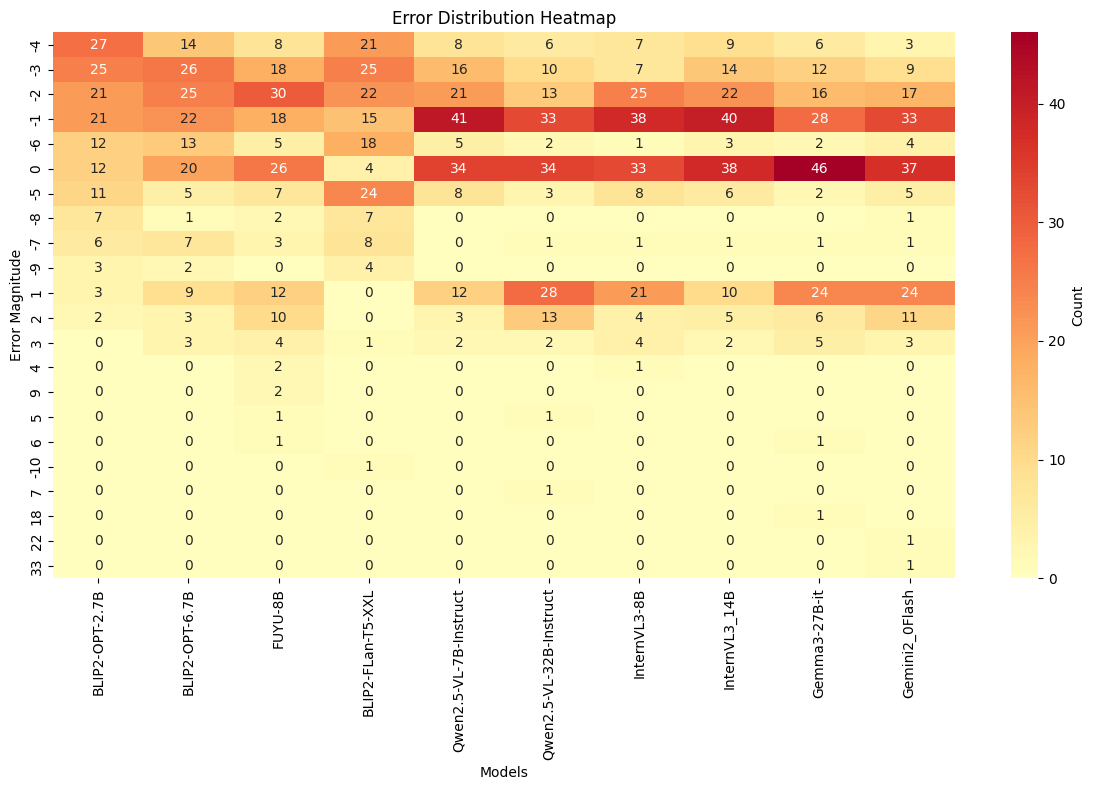

In [13]:
def plot_error_heatmap(model_results_dict):
    """Create a heatmap showing error distribution across categories."""
    plt.figure(figsize=(12, 8))

    # Prepare data for heatmap
    error_counts = {}
    for model, results in model_results_dict.items():
        errors = results['error_distribution']['error_distribution']
        # Count occurrences of each error value
        error_counts[model] = pd.Series(errors).value_counts().to_dict()
    
    # Convert to DataFrame
    error_df = pd.DataFrame(error_counts).fillna(0)
    
    sns.heatmap(error_df, cmap='RdYlBu_r', center=0, 
                annot=True, fmt='.0f',
                cbar_kws={'label': 'Count'})
    
    plt.title('Error Distribution Heatmap')
    plt.xlabel('Models')
    plt.ylabel('Error Magnitude')
    plt.tight_layout()

plot_error_heatmap(model_results)

In [14]:
# def plot_radar_metrics(model_results_dict):
#     """Create a radar plot comparing multiple metrics across models."""
#     metrics = ['MAE', 'MSE', 'RMSE', 'Accuracy']
#     angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False)
    
#     fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))
    
#     for model, results in model_results_dict.items():
#         values = [
#             results['overall_error_metrics']['MAE'],
#             results['overall_error_metrics']['MSE'],
#             results['overall_error_metrics']['RMSE'],
#             results['overall']
#         ]
#         # Normalize values for better visualization
#         values = [v/max(values) for v in values]
#         ax.plot(angles, values, label=model)
#         ax.fill(angles, values, alpha=0.25)
    
#     ax.set_xticks(angles)
#     ax.set_xticklabels(metrics)
#     ax.set_title('Model Performance Radar Plot')
#     plt.legend(bbox_to_anchor=(1.3, 0.3))
#     plt.tight_layout()

# plot_radar_metrics(model_results)

In [15]:
# def plot_error_bubbles(model_results_dict):
#     """Create a bubble plot showing error distribution."""
#     plt.figure(figsize=(12, 8))
    
#     for model, results in model_results_dict.items():
#         errors = results['error_distribution']['error_distribution']
#         error_counts = pd.Series(errors).value_counts()
        
#         plt.scatter(error_counts.index, 
#                    [model] * len(error_counts),
#                    s=error_counts.values * 100,
#                    alpha=0.6,
#                    label=model)
    
#     plt.title('Error Distribution Bubble Plot')
#     plt.xlabel('Error Magnitude')
#     plt.ylabel('Models')
#     plt.grid(True, alpha=0.3)
#     plt.legend()
#     plt.tight_layout()

# plot_error_bubbles(model_results)

In [16]:
# # Error analysis using seaborn
# def plot_error_analysis(model_results_dict):
#     """Create alternative error analysis plots using seaborn."""
#     # Create a figure with multiple subplots
#     fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
#     # 1. Violin Plot for Error Distribution
#     error_data = []
#     model_names = []
#     for model, results in model_results_dict.items():
#         errors = results['error_distribution']['error_distribution']
#         error_data.extend(errors)
#         model_names.extend([model] * len(errors))
    
#     error_df = pd.DataFrame({
#         'Error': error_data,
#         'Model': model_names
#     })
    
#     sns.violinplot(data=error_df, x='Model', y='Error', ax=ax1)
#     ax1.set_title('Error Distribution by Model')
#     ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
    
#     # 2. Box Plot for Error Metrics
#     metrics_data = []
#     for model, results in model_results_dict.items():
#         metrics = results['overall_error_metrics']
#         for metric, value in metrics.items():
#             if metric != 'category' and metric != 'sample_size':
#                 metrics_data.append({
#                     'Model': model,
#                     'Metric': metric,
#                     'Value': value
#                 })
    
#     metrics_df = pd.DataFrame(metrics_data)
#     sns.boxplot(data=metrics_df, x='Model', y='Value', hue='Metric', ax=ax2)
#     ax2.set_title('Error Metrics Distribution')
#     ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
    
#     # 3. KDE Plot for Error Distribution
#     sns.kdeplot(data=error_df, x='Error', hue='Model', ax=ax3)
#     ax3.set_title('Error Distribution Density')
    
#     # 4. Swarm Plot for Error Distribution
#     sns.swarmplot(data=error_df, x='Model', y='Error', ax=ax4)
#     ax4.set_title('Error Distribution by Model')
#     ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45)
    
#     plt.tight_layout()
#     # plt.savefig('error_analysis_alternative.png', bbox_inches='tight', dpi=300)
#     # plt.close()

# plot_error_analysis(model_results)

In [17]:
# def plot_accuracy_analysis(model_results_dict):
#     """Create accuracy analysis plots."""
#     # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
#     # 1. Cumulative Accuracy Plot
#     plt.figure(figsize=(10, 6))
    
#     for model, results in model_results_dict.items():
#         off_by_n = results['off_by_n']
#         # Get the maximum N from the available keys
#         max_n = max([int(k.split('_')[-1]) for k in off_by_n.keys() if k.startswith('off_by_')])
#         tolerances = list(range(max_n + 1))
#         accuracies = [off_by_n[f'off_by_{i}'] for i in range(max_n + 1)]
        
#         plt.plot(tolerances, accuracies, marker='o', label=model)

#     # Add baseline markers
#     baseline_colors = ['darkred', 'darkred', 'darkred']  # Same color for all baselines
#     baseline_styles = ['--', ':', '-.']  # Different line styles
#     baseline_labels = ['Random Baseline', 'Off-by-1 Baseline', 'Off-by-2 Baseline']
#     baseline_values = [0.0909, 0.2562, 0.4050]  # Your baseline values
    
#     for value, style, label, color in zip(baseline_values, baseline_styles, baseline_labels, baseline_colors):
#         plt.axhline(y=value, color=color, linestyle=style, alpha=0.5, label=label)
    
#     plt.title('Cumulative Accuracy by Tolerance')
#     plt.xlabel('Tolerance (N)')
#     plt.ylabel('Cumulative Accuracy')
#     plt.grid(True, alpha=0.3)
#     plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#     plt.tight_layout()
#     # plt.savefig('cumulative_accuracy.png', bbox_inches='tight', dpi=300)
#     # plt.close()
    
#     # 2. Accuracy Distribution by Category
#     plt.figure(figsize=(10, 6))
    
#     categories = ['Direct Recognition', 'Property Inference', 'Counterfactual']
#     x = np.arange(len(categories))
#     width = 0.8 / len(model_results_dict)
    
#     for i, (model, results) in enumerate(model_results_dict.items()):
#         accuracies = [results['question_type'][cat] for cat in categories]
#         plt.bar(x + i*width, accuracies, width, label=model)
    
#     plt.title('Accuracy Distribution by Question Type')
#     plt.xticks(x + width * (len(model_results_dict)-1)/2, categories)
#     plt.ylabel('Accuracy')
#     plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#     plt.grid(True, alpha=0.3)
#     plt.tight_layout()
#     # plt.savefig('accuracy_by_question_type.png', bbox_inches='tight', dpi=300)
#     # plt.close()

# plot_accuracy_analysis(model_results)

In [18]:
def plot_accuracy_analysis(model_results_dict, selected_models=None):
    """Create cumulative accuracy plot with customizations."""
    import matplotlib.pyplot as plt
    import numpy as np

    # Choose models to plot (in order)
    if selected_models is None:
        # Default: plot all models
        selected_models = list(model_results_dict.keys())
    # Define marker styles for up to 4 models
    marker_styles = ['o', 's', '^', 'D', 'P', '*', 'X', 'v']
    # If more models than markers, cycle through
    marker_map = {model: marker_styles[i % len(marker_styles)] for i, model in enumerate(selected_models)}

    plt.figure(figsize=(10, 6))

    for model in selected_models:
        if model not in model_results_dict:
            continue
        results = model_results_dict[model]
        off_by_n = results['off_by_n']
        max_n = max([int(k.split('_')[-1]) for k in off_by_n.keys() if k.startswith('off_by_')])
        tolerances = list(range(max_n + 1))
        accuracies = [off_by_n[f'off_by_{i}'] * 100 for i in range(max_n + 1)]  # Convert to percentage

        plt.plot(
            tolerances, accuracies,
            marker=marker_map[model],
            label=model,
            linewidth=2,
            markersize=8
        )

    # Baseline markers
    baseline_colors = ['red', 'red', 'red']
    baseline_styles = ['--', ':', '-.']
    baseline_labels = ['Random Baseline', 'Off-by-1 Baseline', 'Off-by-2 Baseline']
    baseline_values = [0.0909, 0.2562, 0.4050]  # As fractions

    for value, style, label, color in zip(baseline_values, baseline_styles, baseline_labels, baseline_colors):
        plt.axhline(y=value * 100, color=color, linestyle=style, alpha=0.5, label=label)  # Convert to percentage

    plt.title('Cumulative Accuracy by Tolerance')
    plt.xlabel('Tolerance (N)')
    plt.ylabel('Cumulative Accuracy (%)')
    plt.ylim(0, 100)
    plt.xticks([0, 1, 2])
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    # plt.show()
    plt.savefig('cumulative_accuracy.png', bbox_inches='tight', dpi=300)
    plt.close()

# Example usage:
# Only plot these models (change as needed)
selected_models = [
    # 'Qwen2.5-VL-7B-Instruct_fp16',
    # 'InternVL3-8B_fp16',
    # 'InternVL2.5-8B-MPO_fp16',
    'FUYU-8B',
    # 'Qwen2.5-VL-32B-Instruct',
    # 'InternVL3_14B',
    'Gemma3-27B-it',
    'Gemini2_0Flash'
]
plot_accuracy_analysis(model_results, selected_models=selected_models)


Question Distribution by Property Category:
                   Count  Percentage
property_category                   
functional            61       40.67
physical              41       27.33
taxonomic             32       21.33
relational            16       10.67


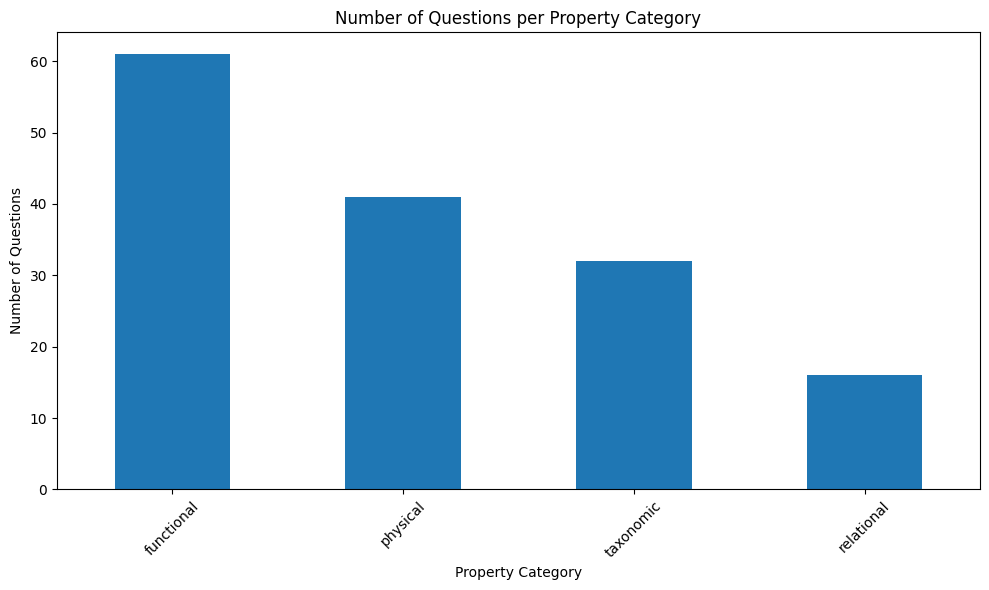

In [19]:
def analyze_question_distribution(results_file):
    """Analyze the distribution of questions across property categories."""
    results = load_results(results_file)
    df = pd.DataFrame(results)
    
    # Count questions per property category
    property_counts = df['property_category'].value_counts()
    
    # Calculate percentages
    property_percentages = (property_counts / len(df) * 100).round(2)
    
    # Create a summary DataFrame
    summary_df = pd.DataFrame({
        'Count': property_counts,
        'Percentage': property_percentages
    })
    
    print("\nQuestion Distribution by Property Category:")
    print(summary_df)
    
    # Visualize the distribution
    plt.figure(figsize=(10, 6))
    property_counts.plot(kind='bar')
    plt.title('Number of Questions per Property Category')
    plt.xlabel('Property Category')
    plt.ylabel('Number of Questions')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    return summary_df

# Usage:
distribution = analyze_question_distribution('/var/scratch/ave303/OP_bench/new_results/InternVL3_results_8b.json')


Property Type Distribution by Question Type:
property_category   functional  physical  relational  taxonomic
question_category                                              
Counterfactual              15        12          12         11
Direct Recognition           0        29           0         21
Property Inference          46         0           4          0

Property Type Distribution by Question Type (Percentage):
property_category   functional  physical  relational  taxonomic
question_category                                              
Counterfactual            30.0      24.0        24.0       22.0
Direct Recognition         0.0      58.0         0.0       42.0
Property Inference        92.0       0.0         8.0        0.0


(property_category   functional  physical  relational  taxonomic
 question_category                                              
 Counterfactual              15        12          12         11
 Direct Recognition           0        29           0         21
 Property Inference          46         0           4          0,
 property_category   functional  physical  relational  taxonomic
 question_category                                              
 Counterfactual            30.0      24.0        24.0       22.0
 Direct Recognition         0.0      58.0         0.0       42.0
 Property Inference        92.0       0.0         8.0        0.0)

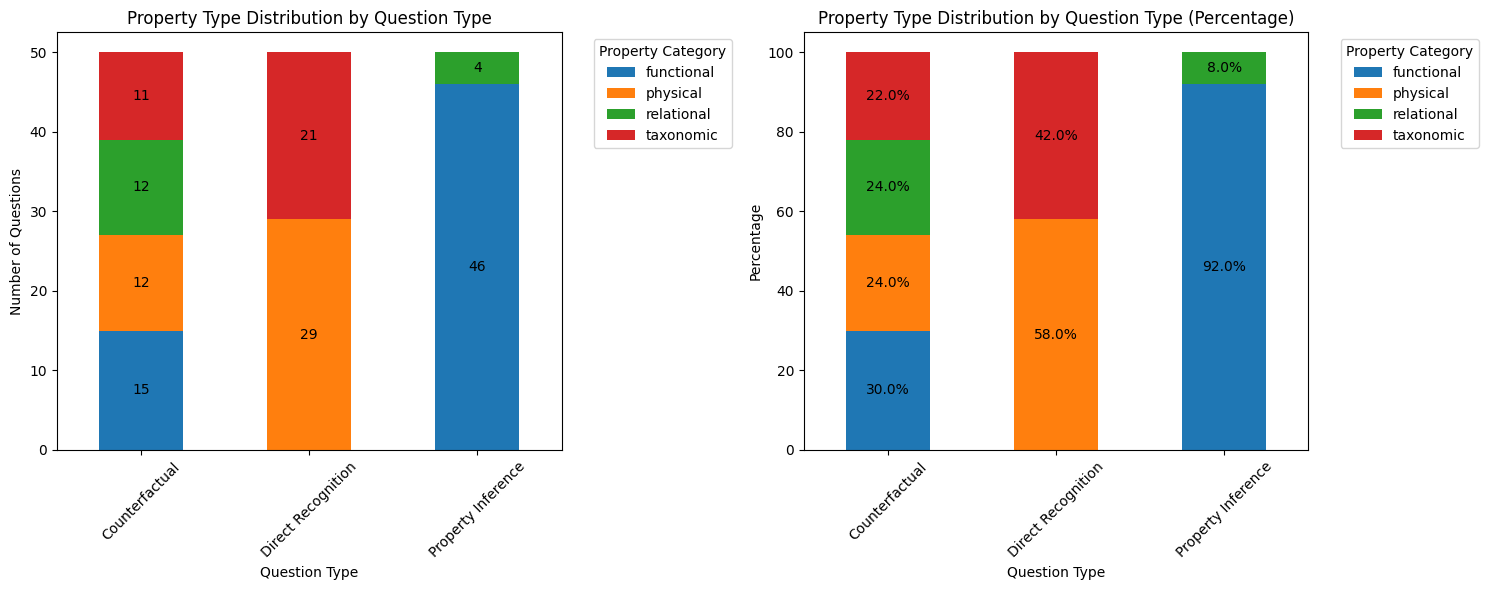

In [20]:
def plot_property_distribution_by_question_type(results_file):
    """Analyze and plot the distribution of property types across question types."""
    results = load_results(results_file)
    df = pd.DataFrame(results)
    
    # Create mapping from question_id to question category
    question_category_map = {
        'Q1': 'Direct Recognition',
        'Q2': 'Property Inference',
        'Q3': 'Counterfactual'
    }
    
    # Add question category column based on question_id
    df['question_category'] = df['question_id'].map(question_category_map)

    # Create a cross-tabulation of question types and property categories
    cross_tab = pd.crosstab(df['question_category'], df['property_category'])
    
    # Calculate percentages for each question type
    cross_tab_pct = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100
    
    # Create the plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 1. Stacked bar chart
    cross_tab.plot(kind='bar', stacked=True, ax=ax1)
    ax1.set_title('Property Type Distribution by Question Type')
    ax1.set_xlabel('Question Type')
    ax1.set_ylabel('Number of Questions')
    ax1.legend(title='Property Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.tick_params(axis='x', rotation=45)

    # Add count labels to the stacked bars
    for c in ax1.containers:
        labels = [f'{int(v)}' if v > 0 else '' for v in c.datavalues]
        ax1.bar_label(c, labels=labels, label_type='center')
    
    # 2. Stacked percentage bar chart
    cross_tab_pct.plot(kind='bar', stacked=True, ax=ax2)
    ax2.set_title('Property Type Distribution by Question Type (Percentage)')
    ax2.set_xlabel('Question Type')
    ax2.set_ylabel('Percentage')
    ax2.legend(title='Property Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.tick_params(axis='x', rotation=45)
    
    # Add percentage labels to the stacked bars
    for c in ax2.containers:
        labels = [f'{v:.1f}%' if v > 5 else '' for v in c.datavalues]
        ax2.bar_label(c, labels=labels, label_type='center')
    
    plt.tight_layout()
    # plt.savefig('property_distribution_by_question_type.png', bbox_inches='tight', dpi=300)
    # plt.close()

    # Print the numerical distribution
    print("\nProperty Type Distribution by Question Type:")
    print(cross_tab)
    print("\nProperty Type Distribution by Question Type (Percentage):")
    print(cross_tab_pct.round(2))
    
    return cross_tab, cross_tab_pct

plot_property_distribution_by_question_type('/var/scratch/ave303/OP_bench/new_results/InternVL3_results_8b.json')

In [21]:
def analyze_accuracy_by_property_and_question(results_file):
    """Analyze accuracy distribution across both property categories and question types."""
    results = load_results(results_file)
    df = pd.DataFrame(results)
    
    # Create mapping from question_id to question category
    question_category_map = {
        'Q1': 'Direct Recognition',
        'Q2': 'Property Inference',
        'Q3': 'Counterfactual'
    }
    
    # Add question category column based on question_id
    df['question_category'] = df['question_id'].map(question_category_map)
    
    # Calculate accuracy for each combination of question type and property category
    accuracy_data = []
    
    for q_type in df['question_category'].unique():
        for p_type in df['property_category'].unique():
            subset = df[(df['question_category'] == q_type) & (df['property_category'] == p_type)]
            if len(subset) > 0:
                correct = sum(subset['model_answer'] == subset['ground_truth'])
                total = len(subset)
                accuracy = correct / total if total > 0 else 0
                accuracy_data.append({
                    'Question Type': q_type,
                    'Property Category': p_type,
                    'Accuracy': accuracy,
                    'Count': total,
                    'Correct': correct
                })
    
    # Convert to DataFrame
    accuracy_df = pd.DataFrame(accuracy_data)
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    
    # Create grouped bar plot
    sns.barplot(data=accuracy_df, 
                x='Question Type', 
                y='Accuracy', 
                hue='Property Category',
                palette='Set2')
    
    plt.title('Accuracy by Question Type and Property Category')
    plt.xlabel('Question Type')
    plt.ylabel('Accuracy')
    plt.legend(title='Property Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # Add count annotations
    for i, row in accuracy_df.iterrows():
        plt.text(i % 3, row['Accuracy'], 
                f'n={row["Count"]}\n({row["Correct"]}/{row["Count"]})',
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('accuracy_by_property_and_question.png', bbox_inches='tight', dpi=300)
    plt.close()
    
    # Print detailed statistics
    print("\nDetailed Accuracy Analysis:")
    print("\nAccuracy by Question Type and Property Category:")
    print(accuracy_df.to_string(index=False))
    
    # Calculate weighted averages
    weighted_avg = accuracy_df.groupby('Question Type').apply(
        lambda x: sum(x['Accuracy'] * x['Count']) / sum(x['Count'])
    )
    print("\nWeighted Average Accuracy by Question Type:")
    print(weighted_avg)
    
    return accuracy_df

In [22]:
# accuracy_analysis1 = analyze_accuracy_by_property_and_question('/var/scratch/ave303/OP_bench/InternVL2.5_results_8bMPO.json')

In [23]:
# accuracy_analysis2 = analyze_accuracy_by_property_and_question('/var/scratch/ave303/OP_bench/InternVL3_results_8b.json')

In [24]:
# accuracy_analysis3 = analyze_accuracy_by_property_and_question('/var/scratch/ave303/OP_bench/Qwen2.5-VL_7b_results.json')

In [25]:
# accuracy_analysis4 = analyze_accuracy_by_property_and_question('/var/scratch/ave303/OP_bench/InternVL3_results_14b.json')

In [26]:
# accuracy_analysis5 = analyze_accuracy_by_property_and_question('/var/scratch/ave303/OP_bench/Qwen2.5-VL_32b_results.json')

In [27]:
# accuracy_analysis6 = analyze_accuracy_by_property_and_question('/var/scratch/ave303/OP_bench/Spacethinker_Qwen2.5-VL_3b_results.json')

In [28]:
accuracy_analysis7 = analyze_accuracy_by_property_and_question('/var/scratch/ave303/OP_bench/new_results/Gemma3_27b_results.json')


Detailed Accuracy Analysis:

Accuracy by Question Type and Property Category:
     Question Type Property Category  Accuracy  Count  Correct
Direct Recognition          physical  0.275862     29        8
Direct Recognition         taxonomic  0.285714     21        6
Property Inference        functional  0.347826     46       16
Property Inference        relational  0.250000      4        1
    Counterfactual          physical  0.250000     12        3
    Counterfactual        functional  0.266667     15        4
    Counterfactual         taxonomic  0.454545     11        5
    Counterfactual        relational  0.250000     12        3

Weighted Average Accuracy by Question Type:
Question Type
Counterfactual        0.30
Direct Recognition    0.28
Property Inference    0.34
dtype: float64


/tmp/ipykernel_2885929/2758041512.py:69: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_avg = accuracy_df.groupby('Question Type').apply(


In [29]:
accuracy_analysis8 = analyze_accuracy_by_property_and_question('/var/scratch/ave303/OP_bench/new_results/Gemini2_0Flash_results.json')


Detailed Accuracy Analysis:

Accuracy by Question Type and Property Category:
     Question Type Property Category  Accuracy  Count  Correct
Direct Recognition          physical  0.241379     29        7
Direct Recognition         taxonomic  0.285714     21        6
Property Inference        functional  0.304348     46       14
Property Inference        relational  0.250000      4        1
    Counterfactual          physical  0.083333     12        1
    Counterfactual        functional  0.266667     15        4
    Counterfactual         taxonomic  0.000000     11        0
    Counterfactual        relational  0.333333     12        4

Weighted Average Accuracy by Question Type:
Question Type
Counterfactual        0.18
Direct Recognition    0.26
Property Inference    0.30
dtype: float64


/tmp/ipykernel_2885929/2758041512.py:69: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_avg = accuracy_df.groupby('Question Type').apply(


In [30]:
accuracy_analysis9 = analyze_accuracy_by_property_and_question('/var/scratch/ave303/OP_bench/new_results/Gemini2_0Flash_results1.json')


Detailed Accuracy Analysis:

Accuracy by Question Type and Property Category:
     Question Type Property Category  Accuracy  Count  Correct
Direct Recognition          physical  0.206897     29        6
Direct Recognition         taxonomic  0.238095     21        5
Property Inference        functional  0.282609     46       13
Property Inference        relational  0.250000      4        1
    Counterfactual          physical  0.083333     12        1
    Counterfactual        functional  0.266667     15        4
    Counterfactual         taxonomic  0.090909     11        1
    Counterfactual        relational  0.250000     12        3

Weighted Average Accuracy by Question Type:
Question Type
Counterfactual        0.18
Direct Recognition    0.22
Property Inference    0.28
dtype: float64


/tmp/ipykernel_2885929/2758041512.py:69: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_avg = accuracy_df.groupby('Question Type').apply(


In [31]:
accuracy_analysis10 = analyze_accuracy_by_property_and_question('/var/scratch/ave303/OP_bench/new_results/Gemma3_27b_results_1.json')


Detailed Accuracy Analysis:

Accuracy by Question Type and Property Category:
     Question Type Property Category  Accuracy  Count  Correct
Direct Recognition          physical  0.275862     29        8
Direct Recognition         taxonomic  0.285714     21        6
Property Inference        functional  0.347826     46       16
Property Inference        relational  0.250000      4        1
    Counterfactual          physical  0.250000     12        3
    Counterfactual        functional  0.266667     15        4
    Counterfactual         taxonomic  0.363636     11        4
    Counterfactual        relational  0.250000     12        3

Weighted Average Accuracy by Question Type:
Question Type
Counterfactual        0.28
Direct Recognition    0.28
Property Inference    0.34
dtype: float64


/tmp/ipykernel_2885929/2758041512.py:69: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_avg = accuracy_df.groupby('Question Type').apply(


In [32]:
accuracy_analysis11 = analyze_accuracy_by_property_and_question('/var/scratch/ave303/OP_bench/new_results/Qwen2.5-VL_3b_results.json')


Detailed Accuracy Analysis:

Accuracy by Question Type and Property Category:
     Question Type Property Category  Accuracy  Count  Correct
Direct Recognition          physical  0.241379     29        7
Direct Recognition         taxonomic  0.428571     21        9
Property Inference        functional  0.260870     46       12
Property Inference        relational  0.250000      4        1
    Counterfactual          physical  0.083333     12        1
    Counterfactual        functional  0.266667     15        4
    Counterfactual         taxonomic  0.363636     11        4
    Counterfactual        relational  0.333333     12        4

Weighted Average Accuracy by Question Type:
Question Type
Counterfactual        0.26
Direct Recognition    0.32
Property Inference    0.26
dtype: float64


/tmp/ipykernel_2885929/2758041512.py:69: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_avg = accuracy_df.groupby('Question Type').apply(


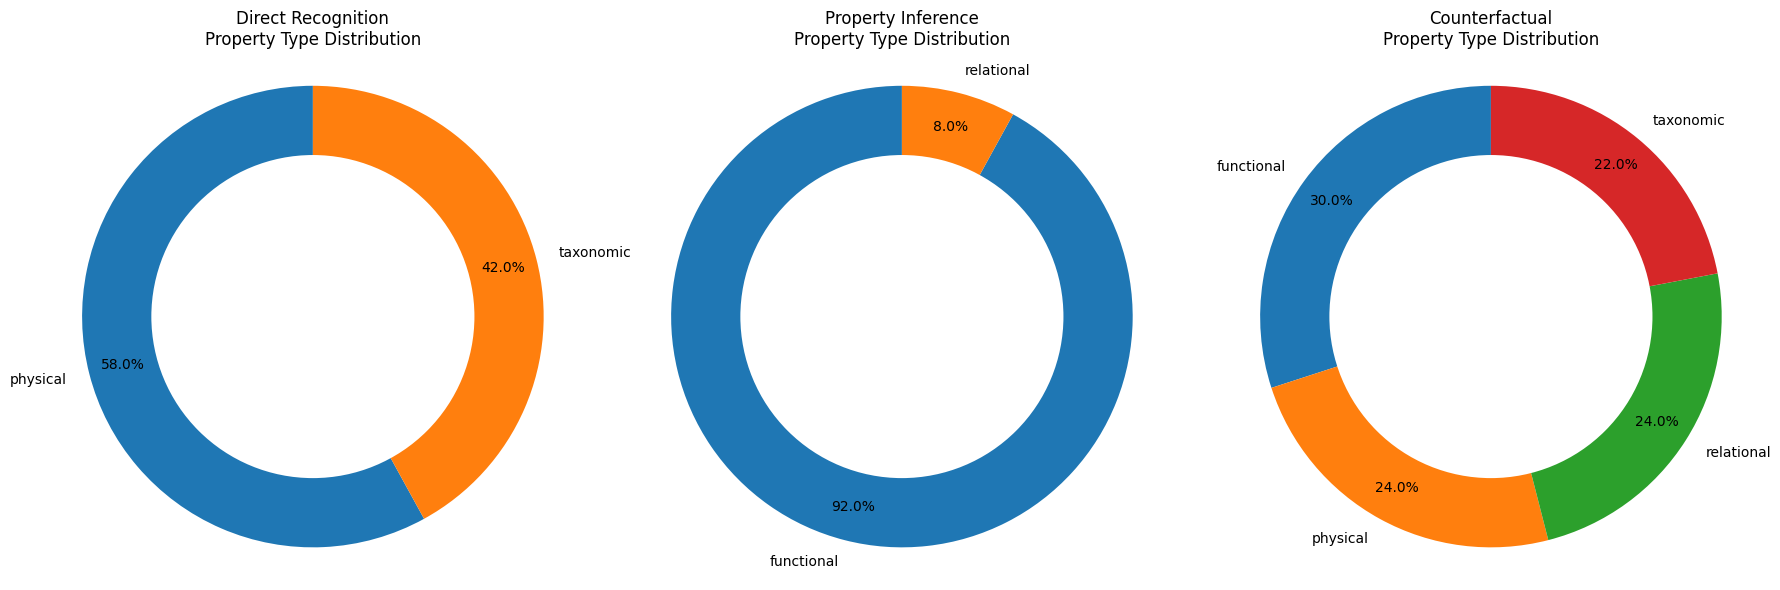

In [33]:
def plot_property_donut_by_question_type(results_file):
    """Plot donut charts of property type distribution for each question type."""
    results = load_results(results_file)
    df = pd.DataFrame(results)
    
    # Map question_id to question category
    question_category_map = {
        'Q1': 'Direct Recognition',
        'Q2': 'Property Inference',
        'Q3': 'Counterfactual'
    }
    df['question_category'] = df['question_id'].map(question_category_map)
    
    property_categories = df['property_category'].unique()
    question_types = df['question_category'].unique()
    
    fig, axes = plt.subplots(1, len(question_types), figsize=(6 * len(question_types), 6))
    if len(question_types) == 1:
        axes = [axes]
    
    for ax, qtype in zip(axes, question_types):
        counts = df[df['question_category'] == qtype]['property_category'].value_counts()
        labels = counts.index
        sizes = counts.values
        wedges, texts, autotexts = ax.pie(
            sizes, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85
        )
        # Draw a circle at the center to make it a donut
        centre_circle = plt.Circle((0,0),0.70,fc='white')
        ax.add_artist(centre_circle)
        ax.set_title(f"{qtype}\nProperty Type Distribution")
        ax.axis('equal')
    
    plt.tight_layout()
    plt.show()

plot_property_donut_by_question_type('/var/scratch/ave303/OP_bench/new_results/Gemma3_27b_results.json')

In [34]:
# def plot_nested_donut(results_file):
#     """Plot a nested donut chart for question type and property type composition."""
#     results = load_results(results_file)
#     df = pd.DataFrame(results)
    
#     # Map question_id to question category
#     question_category_map = {
#         'Q1': 'Direct Recognition',
#         'Q2': 'Property Inference',
#         'Q3': 'Counterfactual'
#     }
#     df['question_category'] = df['question_id'].map(question_category_map)
    
#     # Outer ring: property_category, Inner ring: question_category
#     outer_labels = []
#     outer_sizes = []
#     inner_labels = []
#     inner_sizes = []
    
#     for qtype in df['question_category'].unique():
#         subdf = df[df['question_category'] == qtype]
#         inner_labels.append(qtype)
#         inner_sizes.append(len(subdf))
#         for ptype, count in subdf['property_category'].value_counts().items():
#             outer_labels.append(f"{qtype}\n{ptype}")
#             outer_sizes.append(count)
    
#     # Colors
#     cmap = plt.get_cmap("tab20c")
#     outer_colors = cmap(np.arange(len(outer_labels)))
#     inner_colors = cmap(np.arange(len(inner_labels))*4)
    
#     fig, ax = plt.subplots(figsize=(8,8))
#     ax.pie(inner_sizes, labels=inner_labels, radius=1, colors=inner_colors, wedgeprops=dict(width=0.3, edgecolor='w'))
#     ax.pie(outer_sizes, labels=outer_labels, radius=1.3, colors=outer_colors, wedgeprops=dict(width=0.3, edgecolor='w'))
#     ax.set(aspect="equal")
#     plt.title("Nested Donut: Question Type and Property Type Composition")
#     plt.show()

# plot_nested_donut('/var/scratch/ave303/OP_bench/new_results/Gemma3_27b_results.json')

In [35]:
# import matplotlib.pyplot as plt
# import numpy as np

# def plot_nested_donut_with_labels(results_file):
#     results = load_results(results_file)
#     df = pd.DataFrame(results)
    
#     question_category_map = {
#         'Q1': 'Direct Recognition',
#         'Q2': 'Property Inference',
#         'Q3': 'Counterfactual'
#     }
#     df['question_category'] = df['question_id'].map(question_category_map)
    
#     # Prepare data
#     inner_labels = []
#     inner_sizes = []
#     outer_labels = []
#     outer_sizes = []
#     outer_pct_labels = []
#     color_base = plt.get_cmap("tab10")
#     color_light = plt.get_cmap("Pastel1")
#     color_map = {}
    
#     for i, qtype in enumerate(df['question_category'].unique()):
#         subdf = df[df['question_category'] == qtype]
#         inner_labels.append(qtype)
#         inner_sizes.append(len(subdf))
#         color_map[qtype] = color_base(i)
#         for j, (ptype, count) in enumerate(subdf['property_category'].value_counts().items()):
#             outer_labels.append(f"{ptype}")
#             outer_sizes.append(count)
#             pct = 100 * count / len(subdf)
#             outer_pct_labels.append(f"{count} ({pct:.1f}%)")
    
#     # Colors: inner ring solid, outer ring lighter
#     inner_colors = [color_map[qtype] for qtype in inner_labels]
#     outer_colors = []
#     for qtype in df['question_category'].unique():
#         c = color_map[qtype]
#         # Make lighter for outer ring
#         outer_colors.extend([tuple(np.array(c)*0.6 + 0.4) for _ in df[df['question_category']==qtype]['property_category'].value_counts()])
    
#     fig, ax = plt.subplots(figsize=(9, 7))
#     wedges1, _ = ax.pie(inner_sizes, labels=inner_labels, radius=1, colors=inner_colors, 
#                         wedgeprops=dict(width=0.3, edgecolor='w'), labeldistance=0.7)
#     wedges2, _ = ax.pie(outer_sizes, labels=outer_labels, radius=1.3, colors=outer_colors, 
#                         wedgeprops=dict(width=0.3, edgecolor='w'), labeldistance=1.05)
    
#     # Add value labels to outer wedges
#     for i, w in enumerate(wedges2):
#         ang = (w.theta2 - w.theta1)/2. + w.theta1
#         y = np.sin(np.deg2rad(ang))
#         x = np.cos(np.deg2rad(ang))
#         horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
#         ax.annotate(outer_pct_labels[i], xy=(x*1.45, y*1.45), ha=horizontalalignment, va='center', fontsize=10, fontweight='bold')
    
#     # plt.title("Nested Donut: Question Type and Property Type Composition")
#     plt.tight_layout()
#     plt.show()

# plot_nested_donut_with_labels('/var/scratch/ave303/OP_bench/new_results/Gemma3_27b_results.json')

In [36]:
# import matplotlib.pyplot as plt
# import numpy as np

# def plot_nested_donut_with_inside_labels(results_file):
#     results = load_results(results_file)
#     df = pd.DataFrame(results)
    
#     question_category_map = {
#         'Q1': 'Direct Recognition',
#         'Q2': 'Property Inference',
#         'Q3': 'Counterfactual'
#     }
#     df['question_category'] = df['question_id'].map(question_category_map)
    
#     # Prepare data
#     inner_labels = []
#     inner_sizes = []
#     outer_labels = []
#     outer_sizes = []
#     outer_pct_labels = []
#     color_base = plt.get_cmap("tab10")
#     color_map = {}
    
#     for i, qtype in enumerate(df['question_category'].unique()):
#         subdf = df[df['question_category'] == qtype]
#         inner_labels.append(qtype)
#         inner_sizes.append(len(subdf))
#         color_map[qtype] = color_base(i)
#         for ptype, count in subdf['property_category'].value_counts().items():
#             outer_labels.append(ptype)
#             outer_sizes.append(count)
#             pct = 100 * count / len(subdf)
#             outer_pct_labels.append(f"{pct:.1f}%")
    
#     # Colors: inner ring solid, outer ring lighter
#     inner_colors = [color_map[qtype] for qtype in inner_labels]
#     outer_colors = []
#     for qtype in df['question_category'].unique():
#         c = color_map[qtype]
#         # Make lighter for outer ring
#         outer_colors.extend([tuple(np.array(c)*0.6 + 0.4) for _ in df[df['question_category']==qtype]['property_category'].value_counts()])
    
#     fig, ax = plt.subplots(figsize=(8, 7))
#     # Make the rings wider and the center smaller
#     wedges1, _ = ax.pie(
#         inner_sizes, labels=inner_labels, radius=1, colors=inner_colors, 
#         wedgeprops=dict(width=0.45, edgecolor='w'), labeldistance=0.5
#     )
#     wedges2, _ = ax.pie(
#         outer_sizes, labels=None, radius=1.45, colors=outer_colors, 
#         wedgeprops=dict(width=0.45, edgecolor='w')
#     )
    
#     # Place percentage labels inside the outer wedges
#     for i, w in enumerate(wedges2):
#         ang = (w.theta2 - w.theta1)/2. + w.theta1
#         y = np.sin(np.deg2rad(ang))
#         x = np.cos(np.deg2rad(ang))
#         ax.text(
#             x*1.25, y*1.25, outer_pct_labels[i],
#             ha='center', va='center', fontsize=11, fontweight='bold', color='black'
#         )
    
#     plt.title("Nested Donut: Question Type and Property Type Composition")
#     plt.tight_layout()
#     plt.show()

# plot_nested_donut_with_inside_labels('/var/scratch/ave303/OP_bench/new_results/Gemma3_27b_results.json')

In [37]:
import matplotlib.pyplot as plt
import numpy as np

def plot_nested_donut_with_all_labels(results_file):
    results = load_results(results_file)
    df = pd.DataFrame(results)
    
    question_category_map = {
        'Q1': 'Direct \nRecognition',
        'Q2': 'Property \nInference',
        'Q3': 'Counterfactual'
    }
    df['question_category'] = df['question_id'].map(question_category_map)
    
    # Prepare data
    inner_labels = []
    inner_sizes = []
    outer_labels = []
    outer_sizes = []
    outer_pct_labels = []
    color_base = plt.get_cmap("tab10")
    color_map = {}
    outer_label_map = []
    
    for i, qtype in enumerate(df['question_category'].unique()):
        subdf = df[df['question_category'] == qtype]
        inner_labels.append(qtype)
        inner_sizes.append(len(subdf))
        color_map[qtype] = color_base(i)
        for ptype, count in subdf['property_category'].value_counts().items():
            outer_labels.append(ptype)
            outer_sizes.append(count)
            pct = 100 * count / len(subdf)
            outer_pct_labels.append(f"{ptype}\n{pct:.1f}%")
            outer_label_map.append(qtype)
    
    # Colors: inner ring solid, outer ring lighter
    inner_colors = [color_map[qtype] for qtype in inner_labels]
    outer_colors = []
    for qtype in df['question_category'].unique():
        c = color_map[qtype]
        # Make lighter for outer ring
        outer_colors.extend([tuple(np.array(c)*0.6 + 0.4) for _ in df[df['question_category']==qtype]['property_category'].value_counts()])
    
    fig, ax = plt.subplots(figsize=(8, 7))
    # Make the rings wider and the center smaller
    wedges1, _ = ax.pie(
        inner_sizes, labels=None, radius=1, colors=inner_colors, 
        wedgeprops=dict(width=0.45, edgecolor='w')
    )
    wedges2, _ = ax.pie(
        outer_sizes, labels=None, radius=1.45, colors=outer_colors, 
        wedgeprops=dict(width=0.45, edgecolor='w')
    )
    
    # Place inner ring labels (question types)
    for i, w in enumerate(wedges1):
        ang = (w.theta2 - w.theta1)/2. + w.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        ax.text(
            x*0.75, y*0.75, inner_labels[i],
            ha='center', va='center', fontsize=9.5, fontweight='bold', color='white'
        )
    
    # Place outer ring labels (property type + percentage)
    for i, w in enumerate(wedges2):
        ang = (w.theta2 - w.theta1)/2. + w.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        ax.text(
            x*1.22, y*1.22, outer_pct_labels[i],
            ha='center', va='center', fontsize=8.5, fontweight='bold', color='black'
        )
    
    # plt.title("Nested Donut: Question Type and Property Type Composition")
    ax.text(0, 0, "ORBIT\nComposition", ha='center', va='center', fontsize=15, fontweight='bold', color='black')
    plt.tight_layout()
    # plt.show()
    plt.savefig(f'benchmark_composition.png', bbox_inches='tight', dpi=300)
    plt.close()

plot_nested_donut_with_all_labels('/var/scratch/ave303/OP_bench/new_results/Gemma3_27b_results.json')

In [38]:
def plot_ground_truth_distribution(results_file):
    """Plot the distribution of ground truth counts from 0-10."""
    results = load_results(results_file)
    df = pd.DataFrame(results)

    # Convert ground_truth to integer
    df['ground_truth'] = df['ground_truth'].astype(int)

    # Count occurrences of each ground truth value
    gt_counts = df['ground_truth'].value_counts().sort_index()
    
    # Create a complete range from 0-10, filling missing values with 0
    complete_range = pd.Series(index=range(11), data=0)
    complete_range.update(gt_counts)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(complete_range.index, complete_range.values, 
                   color='skyblue', edgecolor='navy', alpha=0.7)
    
    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{int(height)}', ha='center', va='bottom', fontweight='bold')

    # Y-axis: whole numbers only
    plt.gca().yaxis.get_major_locator().set_params(integer=True)
    
    plt.title('Distribution of Ground Truth Counts (0-10)', fontsize=14, fontweight='bold')
    plt.xlabel('Ground Truth Count', fontsize=12)
    plt.ylabel('Number of Questions', fontsize=12)
    plt.xticks(range(11))
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add total count annotation
    total_questions = len(df)
    plt.text(0.02, 0.98, f'Total Questions: {total_questions}', 
             transform=plt.gca().transAxes, fontsize=10, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    # plt.show()
    plt.savefig(f'Ground_truth_dist.png', bbox_inches='tight', dpi=300)
    plt.close()
    
    # Print the numerical distribution
    print("\nGround Truth Count Distribution:")
    print("Count | Number of Questions | Percentage")
    print("-" * 40)
    for count in range(11):
        num_questions = complete_range[count]
        percentage = (num_questions / total_questions) * 100
        print(f"{count:5d} | {num_questions:18d} | {percentage:8.1f}%")
    
    return complete_range

# Usage example:
plot_ground_truth_distribution('/var/scratch/ave303/OP_bench/new_results/Gemma3_27b_results.json')


Ground Truth Count Distribution:
Count | Number of Questions | Percentage
----------------------------------------
    0 |                  1 |      0.7%
    1 |                 10 |      6.7%
    2 |                 16 |     10.7%
    3 |                 24 |     16.0%
    4 |                 25 |     16.7%
    5 |                 26 |     17.3%
    6 |                 20 |     13.3%
    7 |                  9 |      6.0%
    8 |                  9 |      6.0%
    9 |                  7 |      4.7%
   10 |                  3 |      2.0%


0      1
1     10
2     16
3     24
4     25
5     26
6     20
7      9
8      9
9      7
10     3
dtype: int64

In [39]:
import json
import matplotlib.pyplot as plt

def count_consistent_outputs(results_file, values_to_check):
    """Count how many times each value appears in the 'model_answer' field."""
    with open(results_file, 'r') as f:
        data = json.load(f)
    counts = {str(v): 0 for v in values_to_check}
    for entry in data:
        model_answer = str(entry.get('model_answer', '')).strip()
        for v in values_to_check:
            if model_answer == str(v):
                counts[str(v)] += 1
    return counts

def plot_consistent_output_distribution_from_json(model_files, model_value_map):
    # Color map for values
    value_color_map = {
        '1': ("#a6cee3", "#1f78b4"),  # light blue, dark blue
        '3': ("#b2df8a", "#33a02c"),  # light green, dark green
        '0': ("#fdbf6f", "#ff7f00")   # light orange, dark orange
    }
    bar_labels = []
    bar_heights = []
    bar_colors = []
    bar_edgecolors = []
    legend_handles = {}
    x_positions = []
    xpos = 0

    for model, (file, values) in model_value_map.items():
        counts = count_consistent_outputs(file, values)
        for v in values:
            v_str = str(v)
            bar_labels.append(model if len(values) == 1 else f"{model}\n({v})")
            bar_heights.append(counts[v_str])
            color, edgecolor = value_color_map[v_str]
            bar_colors.append(color)
            bar_edgecolors.append(edgecolor)
            if v_str not in legend_handles:
                legend_handles[v_str] = plt.Rectangle((0,0),1,1,fc=color,ec=edgecolor)
            x_positions.append(xpos)
            xpos += 1

    plt.figure(figsize=(8, 6))
    bars = plt.bar(x_positions, bar_heights, color=bar_colors, edgecolor=bar_edgecolors, width=0.6)
    plt.xticks(x_positions, bar_labels, fontsize=12)
    plt.ylabel("Number of Questions", fontsize=13)
    plt.xlabel("Models", fontsize=13)
    plt.title("BLIP2 series Inductive Bias", fontsize=14, fontweight='bold')
    plt.grid(axis='y', alpha=0.3)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                 f'{int(height)}', ha='center', va='bottom', fontweight='bold')

    # Legend
    plt.legend([legend_handles[v] for v in legend_handles],
               [f"Output value = {v}" for v in legend_handles],
               title="Consistent Output Value", loc='upper right')

    plt.tight_layout()
    # plt.show()
    plt.savefig(f'BLIP2_inductive_bias.png', bbox_inches='tight', dpi=300)
    plt.close()

# Example usage:
model_value_map = {
    "BLIP2-Flan-T5-XXL": ("/var/scratch/ave303/OP_bench/new_results/blip2-flan-t5-xxl_results.json", [0]),
    "BLIP2-OPT-2.7B": ("/var/scratch/ave303/OP_bench/new_results/blip2-opt2.7b_results.json", [1]),
    "BLIP2-OPT-6.7B": ("/var/scratch/ave303/OP_bench/new_results/blip2-opt6.7b_results.json", [1, 3])
}
plot_consistent_output_distribution_from_json(model_value_map, model_value_map)

In [40]:
# %pip install plotly
# %pip install umap-learn


In [41]:
# # Import required libraries
# from sklearn.manifold import TSNE
# import umap.umap_ as umap
# from sentence_transformers import SentenceTransformer
# # import plotly.express as px

# def analyze_error_clusters(predictions, ground_truths, questions, model_name='all-MiniLM-L6-v2'):
#     """
#     Analyze error patterns using t-SNE and UMAP clustering on question embeddings.
    
#     Args:
#         predictions: List of predicted counts
#         ground_truths: List of ground truth counts
#         questions: List of questions
#         model_name: Name of the sentence transformer model to use
#     """
#     # Convert to numeric values
#     preds = [int(str(p)) for p in predictions]
#     truths = [int(str(g)) for g in ground_truths]
    
#     # Find wrong answers
#     wrong_indices = [i for i, (p, t) in enumerate(zip(preds, truths)) if p != t]
#     wrong_questions = [questions[i] for i in wrong_indices]
#     error_magnitudes = [p - t for i, (p, t) in enumerate(zip(preds, truths)) if i in wrong_indices]
    
#     print(f"Number of wrong answers: {len(wrong_questions)}")
    
#     # Get embeddings for wrong questions
#     print("Generating embeddings...")
#     model = SentenceTransformer(model_name)
#     embeddings = model.encode(wrong_questions)
    
#     # Apply t-SNE
#     print("Applying t-SNE...")
#     tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(embeddings)-1))
#     tsne_results = tsne.fit_transform(embeddings)
    
#     # Apply UMAP
#     print("Applying UMAP...")
#     reducer = umap.UMAP(random_state=42, n_neighbors=min(15, len(embeddings)-1))
#     umap_results = reducer.fit_transform(embeddings)
    
#     # Create plots
#     plt.figure(figsize=(15, 6))

#     # t-SNE plot
#     plt.subplot(1, 2, 1)
#     scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], 
#                          c=error_magnitudes, cmap='RdBu', alpha=0.6)
#     plt.colorbar(scatter, label='Error Magnitude')
#     plt.title('t-SNE Clustering of Wrong Answers')
#     plt.xlabel('t-SNE 1')
#     plt.ylabel('t-SNE 2')
    
#     # UMAP plot
#     plt.subplot(1, 2, 2)
#     scatter = plt.scatter(umap_results[:, 0], umap_results[:, 1], 
#                          c=error_magnitudes, cmap='RdBu', alpha=0.6)
#     plt.colorbar(scatter, label='Error Magnitude')
#     plt.title('UMAP Clustering of Wrong Answers')
#     plt.xlabel('UMAP 1')
#     plt.ylabel('UMAP 2')
    
#     plt.tight_layout()
#     plt.show()
    
#     # Print some statistics about the errors
#     print("\nError Statistics:")
#     print(f"Mean error magnitude: {np.mean(error_magnitudes):.2f}")
#     print(f"Std error magnitude: {np.std(error_magnitudes):.2f}")
#     print(f"Min error: {min(error_magnitudes)}")
#     print(f"Max error: {max(error_magnitudes)}")
    
#     # Return the results for further analysis if needed
#     return {
#         'tsne_results': tsne_results,
#         'umap_results': umap_results,
#         'error_magnitudes': error_magnitudes,
#         'wrong_questions': wrong_questions
#     }

# # Example usage:
# # fig_tsne, fig_umap = analyze_error_clusters(predictions, ground_truths, questions)
# # fig_tsne.show()
# # fig_umap.show()

# for model_name, file_path in result_files.items():
#     if Path(file_path).exists():
#         print(f"\nAnalyzing {model_name}...")
#         results = load_results(file_path)
#         df = pd.DataFrame(results)
#         predictions = df['model_answer']
#         ground_truths = df['ground_truth']
#         questions = df['question']
#         outputs = analyze_error_clusters(predictions, ground_truths, questions)
#         # results = analyze_results(file_path, model_name)
#         # model_results[model_name] = results
#         # plot_results(results, model_name)
#         # fig_tsne.show()
#         # fig_umap.show()
        